# Implementing VAR in PyMC3

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

In [2]:
import pymc3 as pm
import theano.tensor as tt

In [3]:
import matplotlib.pyplot as plt
import arviz as az

In [4]:
import pymc3.distributions.transforms as tr

In [5]:
from regime_switching.generate.ar import VARXGenerator

In [6]:
from regime_switching.fit.ar import VAR

# Generate VAR

In [7]:
T = 100
n_endog = 1
n_lag_endog = 2

# n_exog = 0

In [8]:
vg = VARXGenerator.get_random_instance(endog=n_endog, lag_endog=n_lag_endog, random_state=11)
vg

VARXGenerator with params:
  <xarray.Dataset>
  Dimensions:              (endog: 1, exog: 0, lag_endog: 2, lag_exog: 0, pre_vals: 2, target: 1)
  Coordinates:
    * lag_exog             (lag_exog) int64 
    * lag_endog            (lag_endog) int64 1 2
    * endog                (endog) int64 0
    * target               (target) int64 0
    * exog                 (exog) int64 
    * pre_vals             (pre_vals) int64 -2 -1
  Data variables:
      coef_ar              (target, endog, lag_endog) float64 -0.3071 0.2252
      coef_exog            (target, exog, lag_exog) float64 
      coef_covariance      (target, endog) float64 0.1618
      coef_const           (target) float64 -0.9139
      coef_initial_values  (pre_vals, target) float64 -0.8867 -0.8657

In [9]:
data = vg.generate(T + n_lag_endog)
data

<xarray.Dataset>
Dimensions:  (target: 1, time: 102)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 93 94 95 96 97 98 99 100 101
  * target   (target) int64 0
Data variables:
    output   (time, target) float64 -0.834 -0.3058 -0.5152 ... -1.153 -0.5991

## Test in model

### Build model

In [10]:
import warnings

warnings.simplefilter('ignore', FutureWarning)

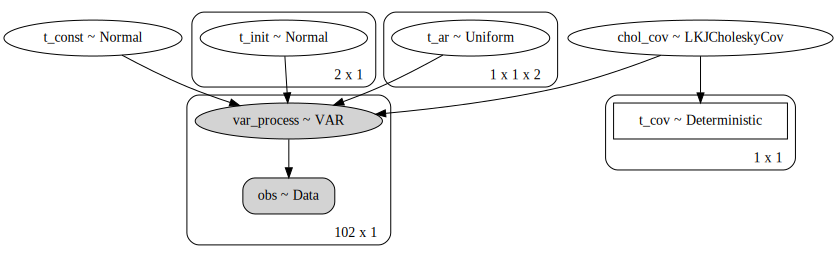

In [11]:
with pm.Model() as m:
    cov_sd_dist = pm.HalfCauchy.dist(beta=2.5)
    cov_eta = 2
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=cov_eta, n=n_endog, sd_dist=cov_sd_dist)
    # chol = pm.expand_packed_triangular(n_endog, packed_chol, lower=True)
    # cov = pm.Deterministic('t_cov', tt.dot(chol, chol.T))
    
    pm.Normal('t_const', 0, 10, shape=(n_endog,))
    pm.Normal('t_init', 0, 10, shape=(n_lag_endog, n_endog))

    # Note: maybe try Beta? Truncated Cauchy/Normal?
    pm.Uniform('t_ar', -1, 1, shape=(n_endog, n_endog, n_lag_endog))
    
    obs = pm.Data('obs', data['output'].values)
    var = VAR(
        'var_process', 
        n_endog=n_endog, n_lag_endog=n_lag_endog, 
        t_const=m['t_const'], 
        t_init=m['t_init'],
        t_ar=m['t_ar'],
        packed_chol=packed_chol, 
        observed=m['obs'],
    )
    cov = pm.Deterministic('t_cov', var.distribution.cov)

pm.model_to_graphviz(m)

### Fit

In [12]:
with m:
    trace = pm.sample(draws=1000, tune=2000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [t_ar, t_init, t_const, chol_cov]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [04:16<00:00, 23.40draws/s]


### Get posterior predictive

In [13]:
with m:
    ppc = pm.sample_posterior_predictive(trace, samples=100)

/opt/conda/envs/rs-model/lib/python3.8/site-packages/pymc3/sampling.py:1246: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(
100%|██████████| 100/100 [01:24<00:00,  1.18it/s]


### Check traces

In [14]:
ifd = az.from_pymc3(
    trace=trace, 
    posterior_predictive=ppc,
    # dims={'var_process': ['time', 'draw']},
    coords={
        'time': np.arange(T), 
        'target': np.arange(n_endog), 
        'endog': np.arange(n_endog),
    }
)

arviz.data.io_pymc3 - WARNING - posterior predictive variable var_process's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


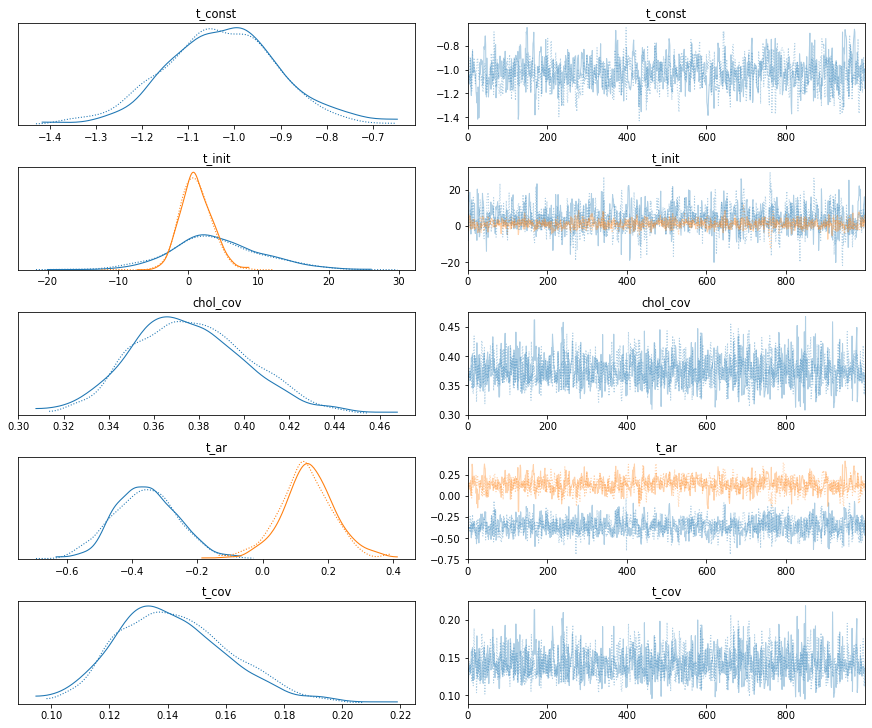

In [15]:
pm.traceplot(trace);

### Check posterior predictive

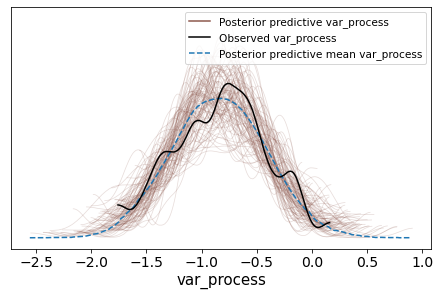

In [16]:
az.plot_ppc(ifd);

### Compare with actual values

In [17]:
import textwrap

In [18]:
_cm = ifd.posterior.mean(dim=['chain', 'draw'])

def chk(name, actual):
    print(f"{name}:")
    print(textwrap.indent(f"{actual.values}", ' ' * 4))
    print("    vs")
    print(textwrap.indent(f"{_cm[name].values}", ' ' * 4))
    
print("Checking coefficients")
chk('t_ar', vg.coef_ar)
chk('t_const', vg.coef_const)
chk('t_cov', vg.coef_covariance)
chk('t_init', vg.coef_initial_values)

Checking coefficients
t_ar:
    [[[-0.3071447   0.22522923]]]
    vs
    [[[-0.35812398  0.13580804]]]
t_const:
    [-0.91393297]
    vs
    [-1.02699598]
t_cov:
    [[0.16180308]]
    vs
    [[0.14221877]]
t_init:
    [[-0.88670056]
     [-0.86573359]]
    vs
    [[3.90570767]
     [1.08379848]]


### Plot range from PPC

In [19]:
vppc = ifd.posterior_predictive.rename({'var_process_dim_0': 'time', 'var_process_dim_1': 'target'})
v_mean = vppc['var_process'].mean(dim=['chain', 'draw'])
_v_hdi = az.hdi(vppc, hdi_prob=0.95)
_v_hdi['hdi'] = ['lower', 'upper']
v_hdi = _v_hdi['var_process'].to_dataset(dim='hdi')
v_vals = v_hdi.combine_first(v_mean.to_dataset(name='mean'))

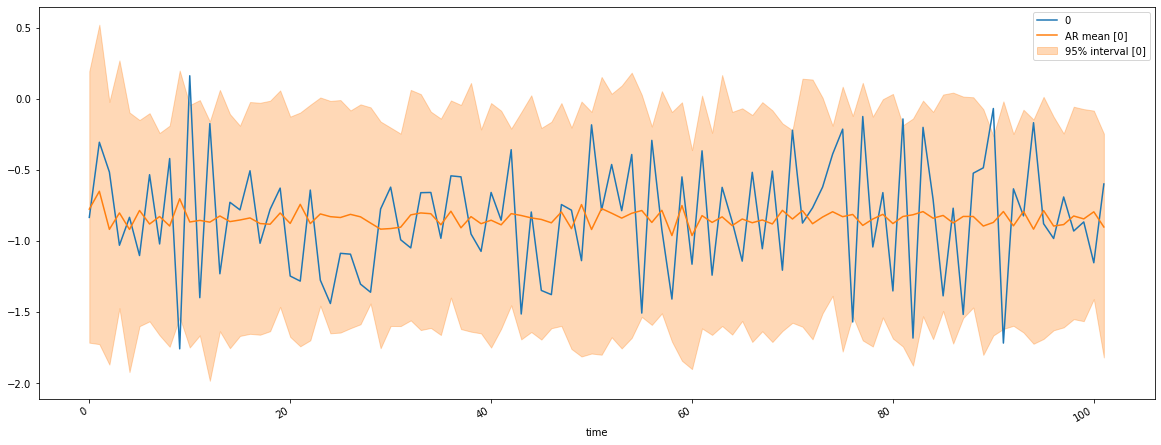

In [20]:
import matplotlib.pyplot as plt

axs = data['output'].to_series().unstack('target').plot(color='C0', figsize=(20, 8), subplots=True)
fig = axs[0].figure
for i, ax in enumerate(axs):
    hh = v_vals.isel(target=i)
    
    ax.plot(
        hh['time'], 
        hh['mean'].values, 
        color='C1', 
        label=f'AR mean [{i}]',
    )
    ax.fill_between(
        hh['time'], 
        hh['lower'].values, 
        hh['upper'].values, 
        color='C1', alpha=0.3, 
        label=f"95% interval [{i}]",
    )
    # v_mean.to_series().unstack('target').plot(color='C1', ax=axs, subplots=True)
    ax.legend()
fig;